### Preamble

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/python/BayesianFiltering

/content/drive/MyDrive/python/BayesianFiltering


In [3]:
from codebase.utils import split_to_sigma_points
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd

### Definitions and MC approx

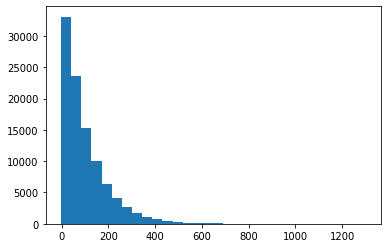

MC approx to mean of Y: 100.03690675030323
MC approx to var of Y: 9892.953321658591
MC approx to cov of X and Y: [5.23110339 3.57809565]


In [65]:
dx = 2

## Random m and P
m = np.zeros(dx) #np.random.multivariate_normal(np.zeros(dx), 100*np.eye(dx)) 
A = np.eye(dx) #100*np.random.rand(dx, dx)
P = 100 * np.dot(A, A.transpose())

# eig = np.array(range(1,dx+1))
# P = np.diag(eig)
Q = 1 
dy = 1
N = 100000

# Definition of non-linearity
## 1
# p = -1/2
# f = lambda x: (1 + np.dot(x,x))**(p/2)
# J = lambda x : p* (1 + np.dot(x,x))**(p/2-1) * x
# H = lambda x : 2*p*(p/2-1)*(1 + np.dot(x,x))**(p/2-2)*np.outer(x,x) + np.eye(dx)*p* (1 + np.dot(x,x))**(p/2-1)

## 2
# f = lambda x: np.sin(np.dot(x,x))/np.dot(x,x)
# J = lambda x: 2 * (np.dot(x,x)*np.cos(np.dot(x,x)) - np.sin(np.dot(x,x))) / (np.dot(x,x))**2 * x
# H = lambda x: -4*(np.sin(np.dot(x,x))/np.dot(x,x) + \
#                   2*(np.cos(np.dot(x,x))*np.dot(x,x) - \
#                      np.sin(np.dot(x,x))) / np.dot(x,x)**3 ) * \
#                      np.outer(x,x) + 2 * (np.dot(x,x)*np.cos(np.dot(x,x)) - \
#                                           np.sin(np.dot(x,x))) / \
#                                           (np.dot(x,x))**2 * np.eye(dx)

## 3 Linear-Nonlinear product <------------------- Hard one
# f = lambda x: x[0] * np.sin(x[1])
# J = lambda x: np.array([np.sin(x[1]), x[0]*np.cos(x[1])])
# H = lambda x: np.array([[0, np.cos(x[1])],[np.cos(x[1]), -x[0]*np.sin(x[1])]])

## 4 Linear-Nonlinear sum
# f = lambda x: x[0] + np.sin(x[1])
# J = lambda x: np.array([1, np.cos(x[1])])
# H = lambda x: np.array([[0,0],[0, -np.sin(x[1])]])

## 5 Quadratic
a = 1
b = 1
A = np.array([[a, 0 ],[0, b]])
f = lambda x: np.dot(x, np.matmul(A,x))/2
J = lambda x: np.matmul(A,x)
H = lambda x: A

# Simulation and visualization
if dx == 1:
  x = np.random.normal(m, P, size = N)
else:
  x = np.random.multivariate_normal(m, P, size = N)
y = np.array(list(map(f, x))) + np.random.normal(0, Q, N)

plt.hist(y, 30)
plt.show()


meanY_MC = np.mean(y)
varY_MC = np.var(y)
covXY_MC = np.matmul(np.transpose(x-m),y-np.mean(y))/(N-1)


print('MC approx to mean of Y:', meanY_MC)
print('MC approx to var of Y:', varY_MC)
print('MC approx to cov of X and Y:', covXY_MC)

In [125]:
f(m)

0.886121853130747

### 1. 2nd order Taylor

In [66]:
meanY_L = f(m) + (1/2) * np.trace(np.matmul(H(m), P))
if dx == 1:
  varY_L = Q + J(m) * P *J(m) 
  covXY_L = P * J(m)
else:
  varY_L = Q + np.dot(J(m), np.matmul(P,J(m))) + (1/2) * np.trace(np.matmul(np.matmul(H(m), P), np.matmul(H(m), P)))
  covXY_L = np.matmul(P, J(m))

### 2. Unscented Transform

In [67]:
alpha = 1e-3
beta = 2
lam = (alpha**2-1)*dx
sigma_points = split_to_sigma_points(m, P, lam)
Y_sigma_points = np.array(list(map(f, sigma_points)))

meanY_U = (lam / (dx+lam))*Y_sigma_points[0] + 1 / (2*(dx+lam)) * sum(Y_sigma_points[1:])
varY_U = Q + (lam/(dx+lam) + 1 - alpha**2 + beta) * (Y_sigma_points[0]-meanY_U)**2 + \
                           1/(2*(dx+lam)) * sum((Y_sigma_points[1:]-meanY_U)**2)

covXY_U = (lam/(dx+lam) + 1 - alpha**2 + beta)*(Y_sigma_points[0]-meanY_U)*(sigma_points[0] - m) + \
                           1/(2*(dx+lam))* np.matmul((Y_sigma_points[1:]-meanY_U), (sigma_points[1:] - m))

### 3. Augmented Linearization

#### m=1

In [68]:
mz = np.array([0])
Nz = 10000

# Projection
Delta = P - (np.trace(np.matmul(H(m),P)) / np.trace(np.matmul(H(m),H(m)))) * H(m)

evals, evecs = np.linalg.eig(P-Delta)
maxloc = np.argmax(evals)
Pz = evals[maxloc]
Gamma = evecs[maxloc]


# MC approx of z-integral
if Pz<0: 
  print('Error, negative variance at i=',i)
else:
  z = np.random.normal(mz, Pz, Nz)
  x_tilde = np.outer(z, Gamma) + m
  y_tilde = np.array(list(map(f, x_tilde)))
  meanY_AL1 = np.mean(y_tilde)
  gradients = np.array(list(map(J, x_tilde)))
  varY_AL1 = Q + sum((y_tilde-meanY_AL1)**2)/Nz + np.trace(np.matmul(np.matmul(gradients, Delta), np.transpose(gradients)))/Nz
  covXY_AL1 = np.matmul(Delta, np.mean(gradients, axis =0)) + np.matmul(np.transpose(x_tilde - m), y_tilde - meanY_AL1) / Nz


In [69]:
print(Delta)
np.linalg.eig(Delta)

[[0. 0.]
 [0. 0.]]


(array([0., 0.]), array([[1., 0.],
        [0., 1.]]))

In [70]:
# plt.plot(meanError)
# plt.title('error')
# plt.show()
# plt.plot(trace)
# plt.title('trace')
# plt.show()
# plt.plot(mat_diff)
# plt.title('P-Delta Frobenius')
# plt.show()
# print('Best value:', np.argmin(meanError))

#### m=2

In [92]:
Nz = 100

# Projection 
if np.trace(H(m))!=0:
  Delta = P - (np.trace(np.matmul(H(m),P)) / np.trace(np.matmul(H(m),H(m)))) * H(m)
else:
  Delta = P

# if np.trace(H(m))!=0:
#   Delta = np.diag(np.diag(P)) - (np.trace(np.matmul(H(m),np.diag(np.diag(P)))) / np.trace(np.matmul(H(m),H(m)))) * H(m)
# else:
#   Delta = np.diag(np.diag(P))


mz = m
Pz = P-Delta


# # MC approx of z-integral
z = np.random.multivariate_normal(mz, Pz, Nz)
x_tilde = z
y_tilde = np.array(list(map(f, x_tilde)))
meanY_AL2 = np.mean(y_tilde)
gradients = np.array(list(map(J, x_tilde)))
varY_AL2 = Q + sum((y_tilde-meanY_AL2)**2) / Nz + np.trace(np.matmul(np.matmul(gradients, Delta), np.transpose(gradients)))/Nz
covXY_AL2 = np.matmul(Delta, np.mean(gradients, axis =0)) + np.matmul(np.transpose(x_tilde - m), y_tilde - meanY_AL2) / Nz

# Quadrature approx of z-integral
# z = split_to_sigma_points(mz, Pz, lam)
# x_tilde = z
# y_tilde = np.array(list(map(f, x_tilde)))
# gradients = np.array(list(map(J, x_tilde)))
# w0m = lam/(dx+lam)
# wim = 1/(2*(dx+lam))
# w0c =  ( lam / (dx + lam) + 1 - alpha**2 + beta)
# wic = wim

# meanY_AL2 = w0m*y_tilde[0] + wim*sum(y_tilde[1:])


# varY_AL2 = Q + w0c * (y_tilde[0]-meanY_AL2)**2 + wic *sum((y_tilde[1:]-meanY_AL2)**2) + \
#               w0c * np.matmul(np.matmul(gradients[0], Delta), np.transpose(gradients[0])) + \
#               wic * np.trace(np.matmul(np.matmul(gradients[1:], Delta), np.transpose(gradients[1:])))

# covXY_AL2 = w0c * (y_tilde[0]-meanY_AL2)*(x_tilde[0] - m) +  wic * np.matmul((y_tilde[1:]-meanY_AL2), (x_tilde[1:] - m)) + \
#           w0c * np.matmul(Delta, gradients[0]) + wic * np.matmul(Delta, np.mean(gradients[1:], axis =0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: covariance is not positive-semidefinite.


In [72]:
# print(sum(minEig>0))
# print(minEig)
# print(meanError)
# print(np.argmin(meanError))
# plt.plot(meanError)
# plt.show()

### Results

In [93]:
df = pd.DataFrame(columns = [' ','MC','L','U','AL1','AL2'])
df[' '] = ['meanY', 'errMean', 'varY', 'errVar', 'covXY']
df['MC'] = [meanY_MC, 0, varY_MC, 0, covXY_MC]
df['L'] = [meanY_L, abs(meanY_L-meanY_MC), varY_L, abs(varY_L - varY_MC), covXY_L]
df['U'] = [meanY_U, abs(meanY_U-meanY_MC),varY_U, abs(varY_U - varY_MC),covXY_U]
df['AL1'] = [meanY_AL1, abs(meanY_AL1-meanY_MC),varY_AL1, abs(varY_AL1 - varY_MC), covXY_AL1]
df['AL2'] = [meanY_AL2, abs(meanY_AL2-meanY_MC),varY_AL2, abs(varY_AL2 - varY_MC), covXY_AL2]
df
# print('-----------Errors of Unscented Approximation----------------')
# print('Error for mean of Y', (meanY_U-meanY_MC)**2 )
# print('Error for var of Y', (varY_U-varY_MC)**2 )
# print('Error for cov of X and Y', np.dot(covXY_MC - covXY_U, covXY_MC - covXY_U))
# print('----------Errors of Augmented Linear Approximation---------')
# print('Error for mean of Y', (meanY_AL-meanY_MC)**2 )
# print('Error for var of Y', (varY_AL-varY_MC)**2 )
# print('Error for cov of X and Y', np.dot(covXY_MC - covXY_AL,covXY_MC - covXY_AL))

,,MC,L,U,AL1,AL2
0,meanY,100.036907,100.0,100.0,4968.849524,12.840572
1,errMean,0,0.036907,0.036907,4868.812617,87.196335
2,varY,9892.953322,10001.0,20001.0,52664771.176067,1598.243109
3,errVar,0,108.046678,10108.046678,52654878.222745,8294.710213
4,covXY,"[5.231103386309293, 3.5780956461517563]","[0.0, 0.0]","[0.0, 0.0]","[17469.897232326908, 0.0]","[51.7121504737418, 127.05558638757735]"


In [85]:
A = np.random.rand(dx, dx)
Mr = np.dot(A, A.transpose())
Mr = Mr / np.sqrt(np.trace(np.matmul(Mr,Mr)))
DD = Mr - (np.trace(np.matmul(H(m),Mr)) / np.trace(np.matmul(H(m),H(m)))) * H(m)
DD

array([[-0.12448586,  0.08670278],
       [ 0.17050436, -0.00423629]])

In [89]:
np.linalg.eig(P-DD)

(array([100.20000101,  99.92872114]), array([[ 0.75408235,  0.40495339],
        [-0.65677987,  0.91433733]]))